# DICE Confidence Checks

In [40]:
from __future__ import annotations
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))


%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns


from recourse_methods import dice_method
from core import recourse_iterator
from confidence_checks import synthetic_data, passthrough_adapter, synthetic_model, plotting_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup the data, model, and adapter

### Get the synthetic data

The synthetic dataset has:
* 1 negatively-classified POI at (-1, 0)
* 1 positively-classified 4-point cluster at (0, 2)
* 1 positively-classified 4-point cluster at (1, 2)

Text(0.5, 1.0, 'Synthetic Dataset')

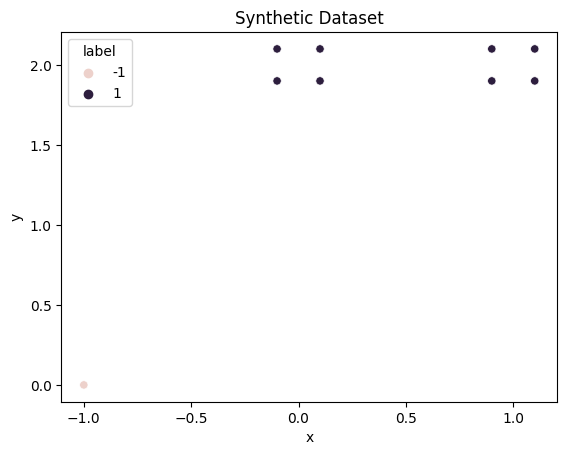

In [41]:
DATASET, DATASET_INFO = synthetic_data.get_data()
POI = DATASET.drop('label', axis=1).iloc[-1]

sns.scatterplot(x='x', y='y', hue="label", data=DATASET)
plt.title("Synthetic Dataset")

### Create a passthrough adapter
For ease of debugging, the adapter doesn't transform the data.

In [42]:
ADAPTER = passthrough_adapter.PassthroughAdapter(
    label_column=DATASET_INFO.label_column,
    positive_label=DATASET_INFO.positive_label
).fit(DATASET)

### Create a simple model

There is a low- to high-confidence gradient from (-1, 0) to (1, 2)

<AxesSubplot: title={'center': 'Model Confidence Contours'}, xlabel='x', ylabel='y'>

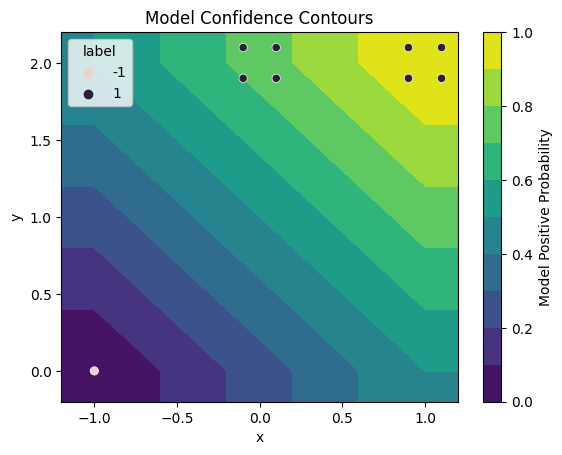

In [43]:
MODEL = synthetic_model.SyntheticModel(ADAPTER)


plotting_functions.plot_model_confidence(MODEL)
plt.title('Model Confidence Contours')
sns.scatterplot(x='x', y='y', hue='label', data=DATASET)

# Check DICE

### Check the DICE recourse directions with confidence threshold

In [44]:
def plot_dice_directions(confidence_threshold):
    dice = dice_method.DiCE(
        k_directions=2,
        adapter=ADAPTER,
        dataset=DATASET,
        desired_confidence=confidence_threshold,
        continuous_features=DATASET_INFO.continuous_features,
        model=MODEL
    )
    plotting_functions.plot_model_confidence(MODEL, xlim=(-1,1.3), ylim=(0, 2.3))
    sns.scatterplot(
        x="x", y="y", data=DATASET, label="Data points", color="red"
    )
    direction_1, direction_2 = dice.get_all_recourse_instructions(POI)
    plotting_functions.plot_direction(direction_1, POI, 'green', 1)
    plotting_functions.plot_direction(direction_2, POI, 'orange', 2)
    plt.title(f"DICE Recourse with Threshold {confidence_threshold}")

When there is no confidence threshold, we expect to see directions close to 0.5 confidence

100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


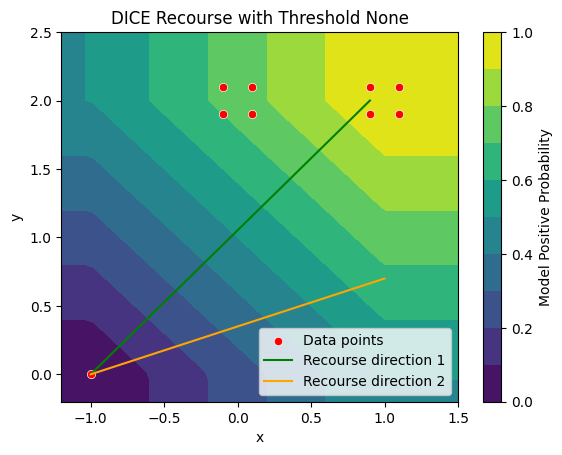

In [45]:
plot_dice_directions(None)

When the threshold is raised, the directions increase in size.

100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


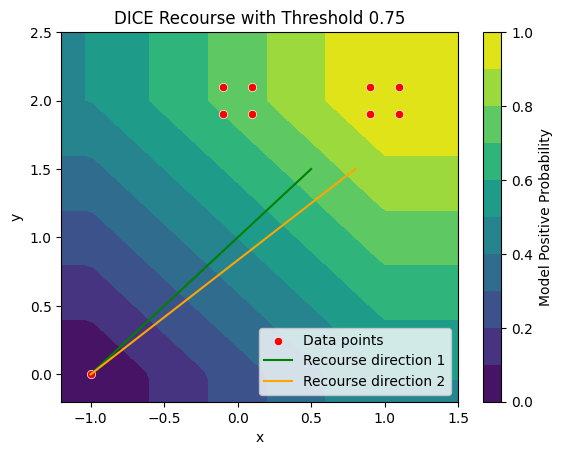

In [46]:
plot_dice_directions(0.75)

100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


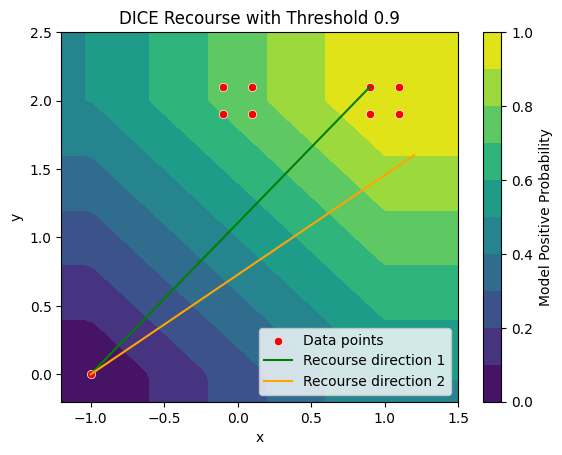

In [47]:
plot_dice_directions(0.9)

# Check MRMC Recourse Iteration

In [48]:
def iterate_recourse(
    max_iterations,
    certainty_cutoff = None,
    confidence_threshold = None,
    model = None,
    perturb_ratio = None,
    rescale_ratio = None):
    """Iterates recourse from MRMC."""
    adapter = passthrough_adapter.PassthroughAdapter(
        label_column=DATASET_INFO.label_column,
        positive_label=DATASET_INFO.positive_label,
        perturb_ratio=perturb_ratio,
        rescale_ratio=rescale_ratio
    ).fit(DATASET)
    
    dice = dice_method.DiCE(
        k_directions=2,
        adapter=ADAPTER,
        dataset=DATASET,
        desired_confidence=confidence_threshold,
        continuous_features=DATASET_INFO.continuous_features,
        model=MODEL
    )
    iterator = recourse_iterator.RecourseIterator(
        recourse_method=dice,
        adapter=adapter,
        certainty_cutoff=certainty_cutoff,
        model=model
    )
    paths = iterator.iterate_k_recourse_paths(POI, max_iterations)
    return paths

def plot_recourse_iteration(
    max_iterations, 
    model,
    certainty_cutoff = None,
    confidence_threshold = None,
    perturb_ratio = None,
    rescale_ratio = None):
    """Plots iterated recourse from MRMC.

    Args:
        max_iterations: The maximum number of recourse steps to take.
        step_size: The size of each recourse step.
        model: The model to generate recourse for.
        certainty_cutoff: A given model confidence to stop iterating at.
        confidence_threshold: A target model confidence to achieve.
        perturb_ratio: How much to perturb the recourse by.
        rescale_ratio: How much to rescale the recourse by.
    """
    paths = iterate_recourse(
        max_iterations=max_iterations,
        certainty_cutoff=certainty_cutoff,
        confidence_threshold=confidence_threshold,
        model=model,
        perturb_ratio=perturb_ratio,
        rescale_ratio=rescale_ratio
    )
    
    plotting_functions.plot_model_confidence(model, xlim=(-1.1, 1.1), ylim=(0,2.2))
    sns.scatterplot(x='x', y='y', data=DATASET, label="Data points", color='red')

    path_colors = ['green', 'orange']
    for i, path in enumerate(paths):
        plotting_functions.plot_path(path, path_colors[i], i+1)
    plt.legend()

If no `certainty_cutoff` is not set, the paths cross the decision boundary and jump around on that side.

100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Text(0.5, 1.0, 'MRMC Recourse Iteration')

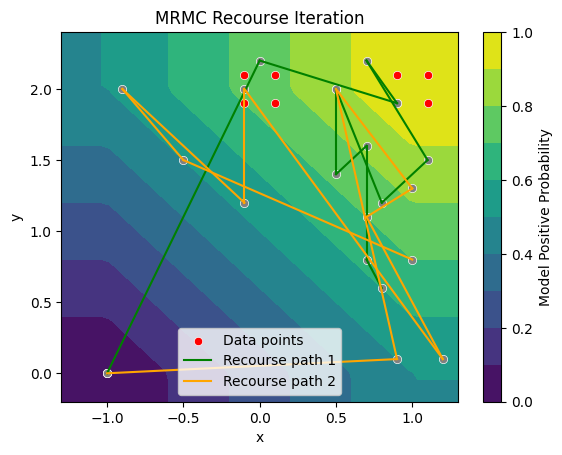

In [68]:
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=None,
    confidence_threshold=None,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("MRMC Recourse Iteration")

If `certainty_cutoff` is set to 0.8, then the paths cross the decision boundary
and jump randomly until they happen to achieve 0.8 confidence.

100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Text(0.5, 1.0, 'Recourse Iteration with Confidence-Based Termination')

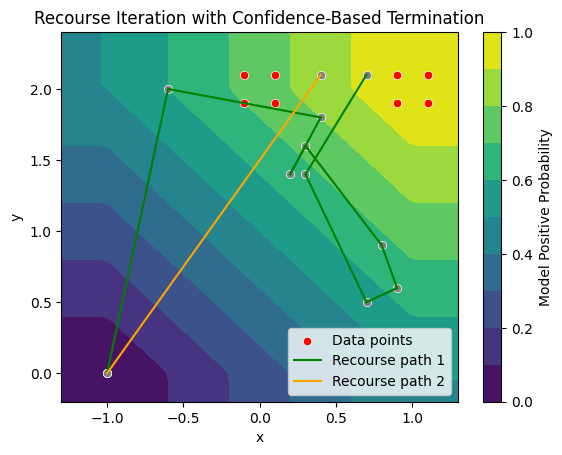

In [51]:
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=None,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("Recourse Iteration with Confidence-Based Termination")

Setting `confidence_threshold` to 0.8 causes both paths to terminate in one step.

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Text(0.5, 1.0, 'Recourse Iteration with Confidence-Based Filtering')

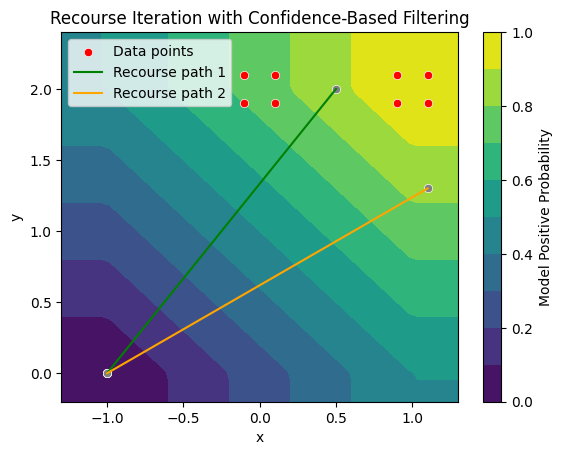

In [53]:
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("Recourse Iteration with Confidence-Based Filtering")

Setting `perturb_ratio` randomly perturbs the direction of each recourse step such that:
1. The perturbations are larger as `perturb_ratio` increases
2. The perturbations don't change the step size


Note that the paths may be perturbed outside of where the model confidence
 contours are rendered, but the confidence is still defined in those areas.

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.1')

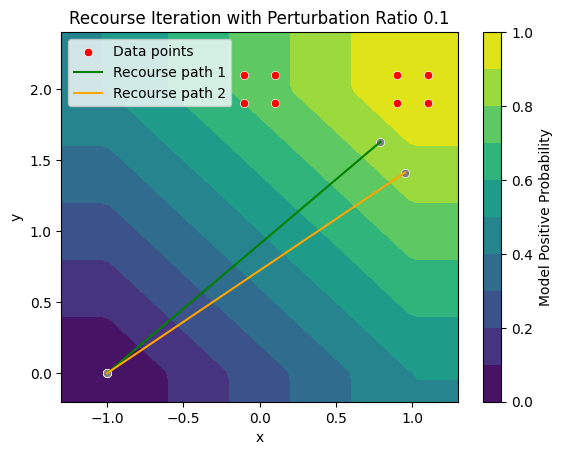

In [63]:
perturb_ratio = 0.1
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.3')

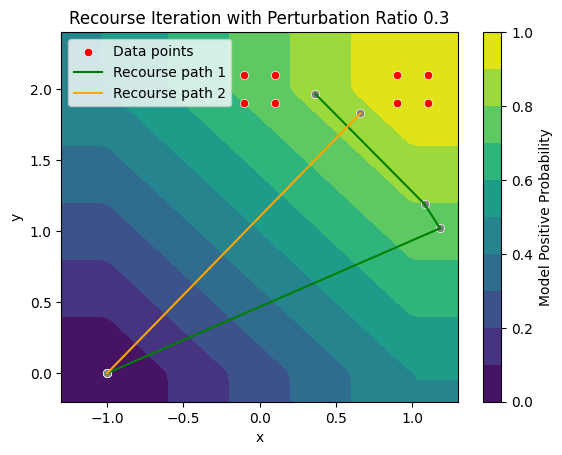

In [56]:
perturb_ratio = 0.3
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.5')

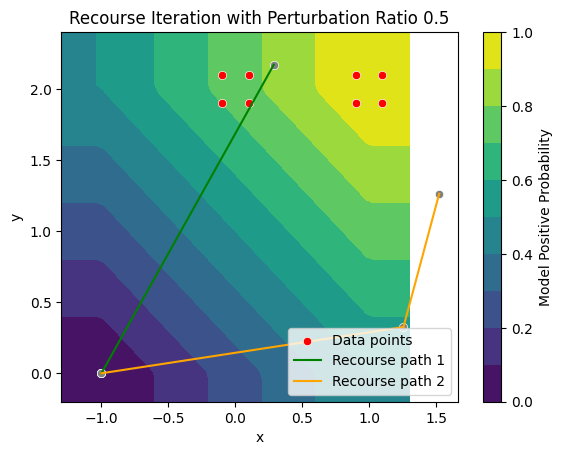

In [65]:
perturb_ratio = 0.5
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.7')

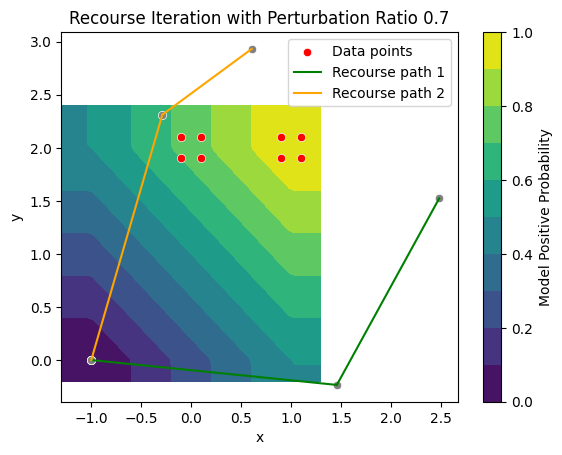

In [58]:
perturb_ratio = 0.7
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.9')

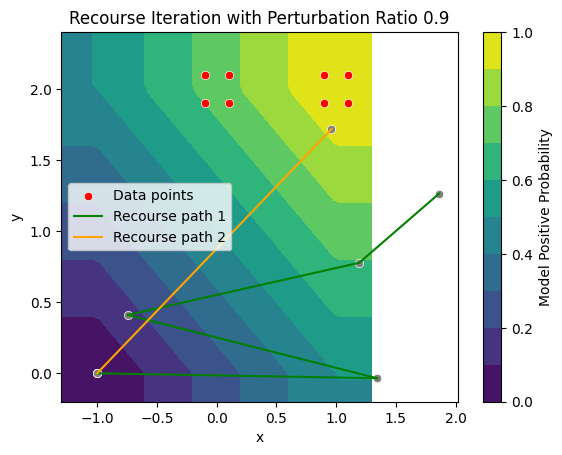

In [67]:
perturb_ratio = 0.9
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 1.2')

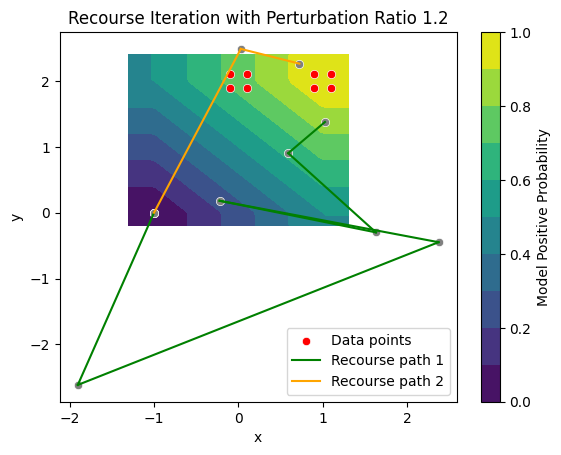

In [60]:
perturb_ratio = 1.2
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 1.5')

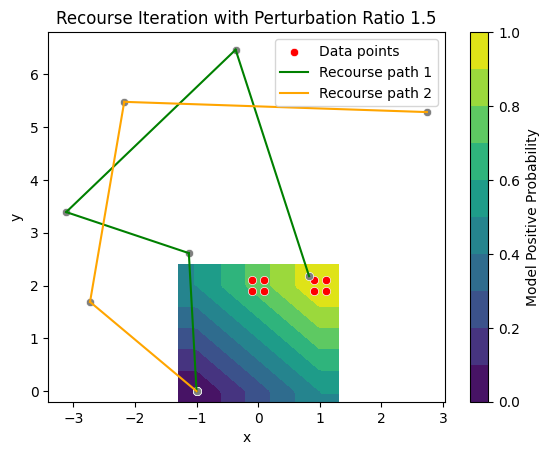

In [61]:
perturb_ratio = 1.5
plot_recourse_iteration(
    max_iterations=10,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")